## Introduction

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## EDA

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
display(labels.info())
display(labels.head(10))
display(labels.describe())
display(labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


(7591, 2)

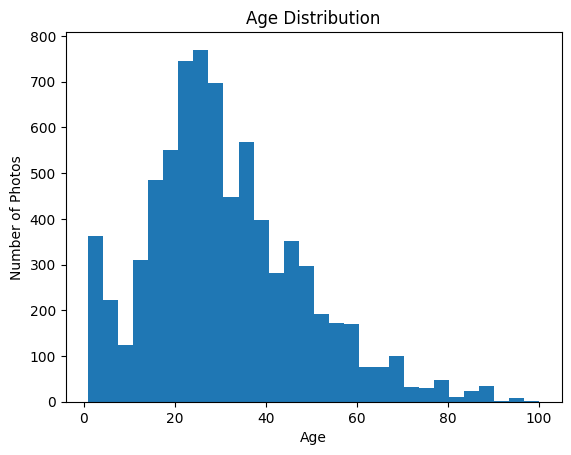

In [5]:
age_dist = labels['real_age'].plot(kind='hist',
                                  title='Age Distribution',
                                  bins=30)
plt.xlabel('Age')
plt.ylabel('Number of Photos')
plt.show()

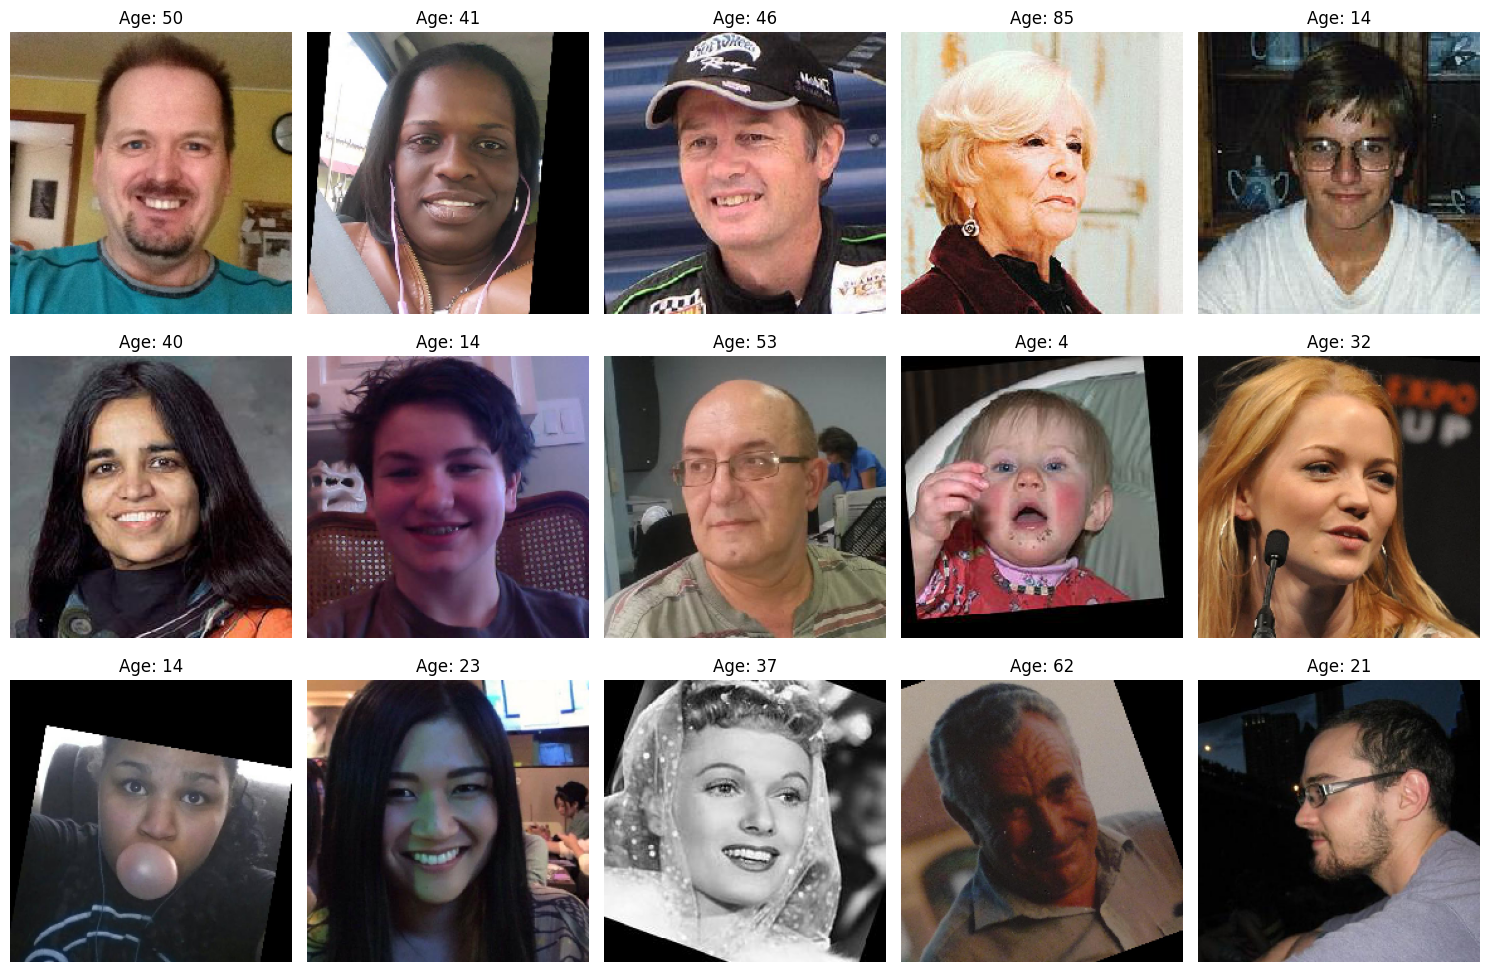

In [6]:
features, targets = next(train_gen_flow)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for img, age, ax in zip(features, targets, axes):
    ax.imshow(img)
    ax.set_title(f'Age: {int(age)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Findings

The age distribution is quite diverse, however, majority of the photos present are of individuals around age 29/30 years old. The distribution is skewed towards younger individuals under 40 years of age - this is further proven by the batch of photos displayed. 

There does appear to be an outlier of 100 years old, but I don't find it reasonable to drop this because I want the model to use this information to predict others around 100 years old - should that be the case.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


In [14]:
def load_train(path, seed=12345):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=seed
    )
    # place your code here

    return train_gen_flow

In [15]:
def load_test(path, seed=12345):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=seed
    )
    # place your code here

    return test_gen_flow

In [16]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False  # Freeze convolutional base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Linear output for regression
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    # place your code here

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        verbose=2
    )
    # place your code here

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512


## Conclusions

Based on the model output results, the Train MAE rapidly improves with each epoch. Starting around a MAE of 7.4 and ending at a MAE around 3.1 reveals good progress. The Validation MAE slowly improved from around a MAE of 8.2 to peaking at epoch 12 with a MAE around 11.5, and then finally landing around a MAE of 7.65. The spike in Val MAE could be possibly due to poor outliers or mislabeling, learning rate instability, or too much dropout variance. The difference in MAE for the train vs val model shows there could be some overfitting involved in the train model.

In conclusion, the model works as intended to identify individual age based on photo and successfully achieved a MAE score less than 8.